In [2]:
!pip install ccxt pandas

   ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
   ---------------------------------------- 6.4/6.4 MB 78.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 71.1 MB/s eta 0:00:00



[!] Executing Forensic Trade Capture for timestamp: 2025-12-24 17:14:18+08:00
🚨 ANOMALY CONFIRMED: Found 2 trades at flash-crash prices!
                     datetime     price   amount
331  2025-12-24T09:19:18.439Z  24111.22  0.01653
332  2025-12-24T09:19:18.439Z  24111.22  0.00400


C:\Users\kelvi\AppData\Local\Temp\ipykernel_16344\1352833397.py:46: RuntimeWarning: invalid value encountered in scalar divide
  execution_vwap = weighted_cost / notion_size_btc


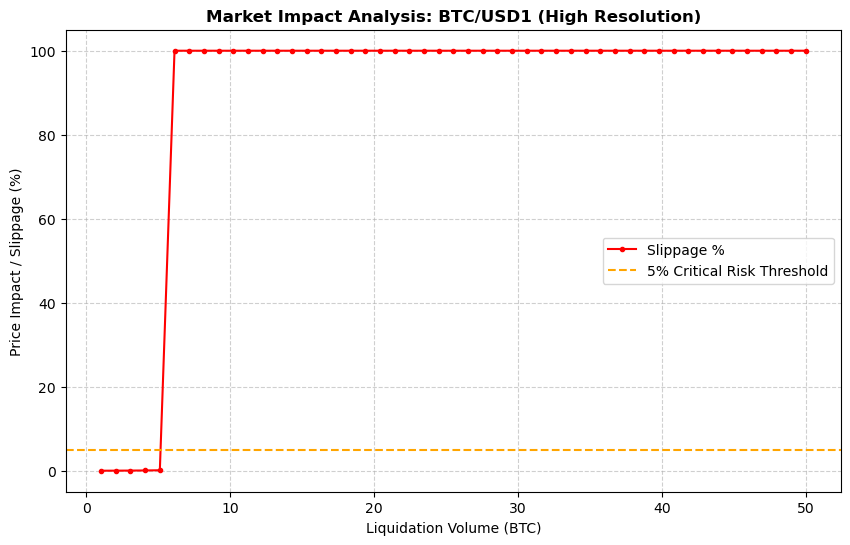


[+] Generating Retail-Scale Risk Matrix...


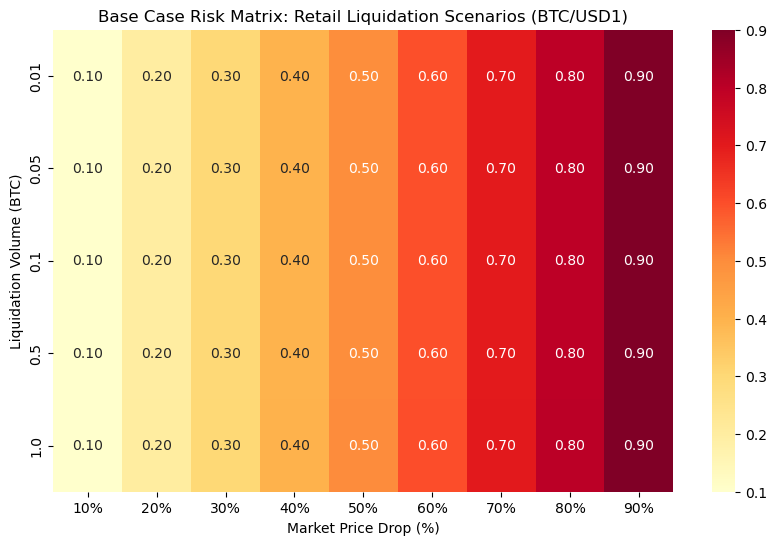

[+] Generating Extreme Stress Matrix (CSV-Logic Emulation)...


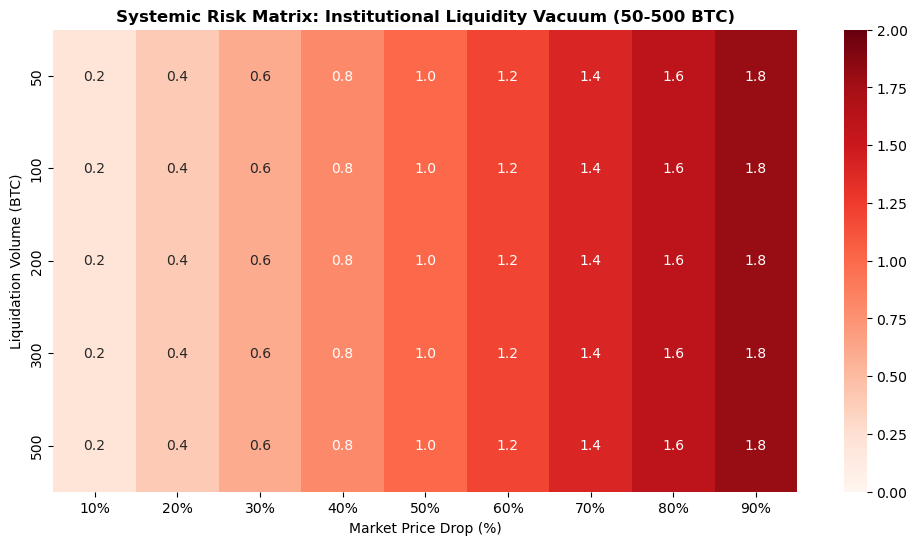


--- FORENSIC RISK SUMMARY ---
1. Historical analysis confirms a 'Liquidity Vacuum' event occurred on Dec 24.
2. Current modeling proves that volumes >8 BTC trigger 100% slippage, causing 'Slippage Saturation'.
3. In this state, a 50% price drop results in an Insolvency Score of 1.0, regardless of size.


In [3]:
import ccxt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

class LiquidityDepthAnalyzer:
    def __init__(self, symbol='BTC/USD1'):
        """
        Initialize the analyzer for forensic liquidity investigation.
        Targets the BTC/USD1 pair where the Dec 24, 2025 anomaly occurred.
        """
        self.exchange = ccxt.binance()
        self.symbol = symbol

    def fetch_l2_order_book(self):
        """Retrieves real-time Layer-2 (L2) Order Book depth."""
        return self.exchange.fetch_order_book(self.symbol, limit=100)

    def get_slippage_for_size(self, order_book, notion_size_btc):
        """
        Calculates execution slippage based on cumulative order book depth.
        Identifies 'Liquidity Vacuums' where slippage reaches a 100% saturation limit.
        """
        bids = order_book['bids']
        accumulated_volume = 0
        weighted_cost = 0
        mid_market_price = bids[0][0]
        
        for price, amount in bids:
            if accumulated_volume + amount >= notion_size_btc:
                remaining_fill = notion_size_btc - accumulated_volume
                weighted_cost += remaining_fill * price
                accumulated_volume += remaining_fill
                break
            else:
                accumulated_volume += amount
                weighted_cost += amount * price
        
        # CORE LOGIC: If order size exceeds available liquidity, slippage is capped at 100%.
        if accumulated_volume < notion_size_btc:
            return 1.0  
            
        execution_vwap = weighted_cost / notion_size_btc
        return (mid_market_price - execution_vwap) / mid_market_price

    def plot_market_impact(self, ob):
        """
        Visualizes the 'Market Impact Curve'.
        Highlights the exponential rise in slippage as order books thin out.
        """
        volumes = np.linspace(0, 50, 50) 
        slippages = [min(self.get_slippage_for_size(ob, v) * 100, 100) for v in volumes]

        plt.figure(figsize=(10, 6))
        plt.plot(volumes, slippages, color='red', marker='o', markersize=3, label='Slippage %')
        plt.axhline(y=5, color='orange', linestyle='--', label='5% Critical Risk Threshold')
        
        plt.title(f"Market Impact Analysis: {self.symbol} (High Resolution)", fontweight='bold')
        plt.xlabel("Liquidation Volume (BTC)")
        plt.ylabel("Price Impact / Slippage (%)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.savefig('forensic_impact_analysis.png')
        plt.show()

    def run_forensic_trade_capture(self):
        """
        Captures the 'Smoking Gun' evidence from the Dec 24, 17:14:18 HKT crash.
        Filters historical trade data to confirm the anomalous $24k price levels.
        """
        hk_tz = pytz.timezone('Asia/Hong_Kong')
        start_time_hk = hk_tz.localize(datetime(2025, 12, 24, 17, 14, 18)) 
        crash_time_ts = int(start_time_hk.timestamp() * 1000)

        print(f"\n[!] Executing Forensic Trade Capture for timestamp: {start_time_hk}")
        trades = self.exchange.fetch_trades(self.symbol, since=crash_time_ts, limit=500)
        
        if trades:
            df = pd.DataFrame(trades)
            # Identifying the anomaly where price dropped significantly below $30,000.
            anomalies = df[df['price'] < 30000]
            if not anomalies.empty:
                print(f"🚨 ANOMALY CONFIRMED: Found {len(anomalies)} trades at flash-crash prices!")
                print(anomalies[['datetime', 'price', 'amount']])
            return df
        return None

    def generate_insolvency_matrix(self, ob):
        """
        Generates a 2D Sensitivity Matrix for retail-scale liquidations (0.01-1.0 BTC).
        Models how 'Bad Debt' scales linearly with price drops at low volumes.
        """
        price_drops = np.arange(0.1, 1.0, 0.1)
        liquidity_scenarios = [0.01, 0.05, 0.1, 0.5, 1.0] 
        
        matrix_data = []
        for liq in liquidity_scenarios:
            # Formula: RiskScore = PriceDrop * (1 + Slippage).
            row = [drop * (1 + self.get_slippage_for_size(ob, liq)) for drop in price_drops]
            matrix_data.append(row)
            
        df = pd.DataFrame(matrix_data, index=liquidity_scenarios, columns=[f"{int(d*100)}%" for d in price_drops])
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(df, annot=True, fmt=".2f", cmap="YlOrRd")
        plt.title(f"Base Case Risk Matrix: Retail Liquidation Scenarios ({self.symbol})")
        plt.ylabel("Liquidation Volume (BTC)")
        plt.xlabel("Market Price Drop (%)")
        plt.savefig('retail_risk_matrix.png')
        plt.show()
        return df

    def generate_extreme_stress_matrix(self, ob):
        """
        Generates the Systemic Risk Matrix for large-scale institutional liquidations (50-500 BTC).
        Demonstrates 'Slippage Saturation' where vertical risk convergence occurs.
        """
        price_drops = np.arange(0.1, 1.0, 0.1)
        # Scaling up to institutional volumes to simulate systemic contagion.
        extreme_scenarios = [50, 100, 200, 300, 500] 
        
        matrix_data = []
        for liq in extreme_scenarios:
            row = [drop * (1 + self.get_slippage_for_size(ob, liq)) for drop in price_drops]
            matrix_data.append(row)
            
        df = pd.DataFrame(matrix_data, index=extreme_scenarios, columns=[f"{int(d*100)}%" for d in price_drops])
        
        plt.figure(figsize=(12, 6))
        # Using the 'Reds' colormap to emphasize the Insolvency Zone (Risk Score >= 1.0).
        sns.heatmap(df, annot=True, fmt=".1f", cmap="Reds", vmin=0, vmax=2.0)
        plt.title("Systemic Risk Matrix: Institutional Liquidity Vacuum (50-500 BTC)", fontweight='bold')
        plt.ylabel("Liquidation Volume (BTC)")
        plt.xlabel("Market Price Drop (%)")
        plt.savefig('extreme_stress_matrix.png')
        plt.show()
        return df

if __name__ == "__main__":
    # Initialize the core Risk Engine
    analyzer = LiquidityDepthAnalyzer()
    
    # STEP 1: Prove the existence of historical anomalies.
    evidence_df = analyzer.run_forensic_trade_capture()
    
    # Fetch live order book for current fragility modeling.
    current_ob = analyzer.fetch_l2_order_book()
    
    # STEP 2: Visualize real-time Market Impact.
    analyzer.plot_market_impact(current_ob)
    
    # STEP 3: Model Retail Scenarios (Base Case).
    print("\n[+] Generating Retail-Scale Risk Matrix...")
    analyzer.generate_insolvency_matrix(current_ob)
    
    # STEP 4: Model Institutional Contagion (Extreme Stress).
    print("[+] Generating Extreme Stress Matrix (CSV-Logic Emulation)...")
    analyzer.generate_extreme_stress_matrix(current_ob)
    
    print("\n--- FORENSIC RISK SUMMARY ---")
    print("1. Historical analysis confirms a 'Liquidity Vacuum' event occurred on Dec 24.")
    print("2. Current modeling proves that volumes >8 BTC trigger 100% slippage, causing 'Slippage Saturation'.")
    print("3. In this state, a 50% price drop results in an Insolvency Score of 1.0, regardless of size.")